# Feature Engineering practice

### Dataset: `IEEE-Fraud-Detection Challenge`

##### TODO list:

Задание 0: выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.

Задание 1: признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

Задание 2: сгруппировать данные по card1 и посчитать среднюю сумму транзакции. Добавить в качестве признака в набор данных. Посчитать разницу между суммой транзакцией пользователя и средней суммой транзакции по данному типу card1. Построить отношение этих признаков. Повторить процедуру для всех card.

Задание 3: преобразовать признаки card_1 - card_6 с помощью Frequency Encoding;

Задание 4: преобразовать признак TransactionAmt в логариф признака, выделить дробную часть и целую часть в отдельные признаки.

Задание 5: для числовых признаков построить PCA-признаки, добавить их к основной части датасета.

Задание 6: использовать критерий отбора признаков на основе перестановок для отбора признаков, которые положительно влияют на перформанс модели. Переобучить модель и сделать выводы о полученном качестве алгоритма.

Задание 7: (опциональное) испольовать SHAP для оценки важности признаков. Использовать SHAP для отбора признаков, проанализировать поведение модели на одном (любом) примере, посмотреть какой вклад каждый признак вносит в итоговый прогно. Проанализировать резульаты.

In [104]:
##############
# Import libs
##############

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
import catboost as catb
import xgboost as xgb
import missingno as msno
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
import shap

from utils.estimators import evaluate_model, fit_catboost
from utils.BuildDataset import encode_labels
from utils.feature_estimators import calculate_feature_separating_ability, calculate_permutation_importance

In [2]:
pd.set_option("max.columns", None)

In [3]:
############
# Data load
############


TRAIN_DATA_PATH = 'data/assignment_train.csv'
TEST_DATA_PATH = 'data/assignment_test.csv'


train = pd.read_csv(TRAIN_DATA_PATH)
test = pd.read_csv(TEST_DATA_PATH)

In [4]:
###########
# Settings
###########
seed = 42
np.random.seed(seed)
discret_limit = 25

ID = 'TransactionID'
DATE = 'TransactionDT'
TARGET = 'isFraud' # Target

CAT_FEATS = train.select_dtypes(include='object').columns  # Categorical
ALL_NUMERICAL_FEATS = train.select_dtypes(include=[np.number]).columns # Numerical + Target
NUMERICAL_FEATS = ALL_NUMERICAL_FEATS.drop([TARGET, ID, DATE]) # Numerical only

# Discrete feature among numerical
DISCRETE_FEATS = [feature for feature in NUMERICAL_FEATS if len(train[feature].unique()) < discret_limit]

print(f"Categorical Features Count: {len(CAT_FEATS)}")
print(f"Numerical Features Count: {len(NUMERICAL_FEATS)}")
print(f"Discrete Features of Numerical Count: {len(DISCRETE_FEATS)}")
print(f"\nTotal Features: {len(train.columns)-1}")

Categorical Features Count: 14
Numerical Features Count: 377
Discrete Features of Numerical Count: 219

Total Features: 393


In [5]:
# Apply Label encoder to all cat feats

train = encode_labels(train)
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,19.0,NaN,34,33,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,0,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,NaN,NaN,16,33,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1,2,2,0,1,1,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,

In [6]:
TRAINABLE_FEATS = train.drop(TARGET, axis=1).columns
TRAINABLE_FEATS

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=393)

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(train[TRAINABLE_FEATS],
                                                      train[TARGET],
                                                      test_size= 0.333,
                                                      stratify=train[TARGET])

# 0. Baseline fixing

Baseline valid score = 0.820285

Train CV-score: 0.8698 std: +/- 0.011

In [63]:
cb_params_1000 = {
    "n_estimators": 1000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 25,
    "verbose": 50,
    "max_depth": 10,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 10,
    "thread_count": 6,
    "random_seed": seed
}

baseline_catb_model = fit_catboost(
            X_train, y_train, cb_params_1000, None, X_valid, y_valid)

evaluate_model(baseline_catb_model, X_train, y_train, X_valid, y_valid)

0:	test: 0.6017706	best: 0.6017706 (0)	total: 325ms	remaining: 5m 24s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8038903746
bestIteration = 31

Shrink model to first 32 iterations.
score = 0.80389
score = 0.820285


### Cross eval

In [21]:
cv = cross_val_score(
    estimator=baseline_catb_model,
    X=train[TRAINABLE_FEATS],
    y=train[TARGET],
    scoring="roc_auc",
    cv=3,
)

print(f"CV-result: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

0:	total: 252ms	remaining: 4m 11s
50:	total: 11.5s	remaining: 3m 34s
100:	total: 22.9s	remaining: 3m 24s
150:	total: 34.6s	remaining: 3m 14s
200:	total: 46s	remaining: 3m 2s
250:	total: 57.8s	remaining: 2m 52s
300:	total: 1m 9s	remaining: 2m 40s
350:	total: 1m 20s	remaining: 2m 29s
400:	total: 1m 31s	remaining: 2m 17s
450:	total: 1m 43s	remaining: 2m 6s
500:	total: 1m 54s	remaining: 1m 54s
550:	total: 2m 6s	remaining: 1m 42s
600:	total: 2m 18s	remaining: 1m 31s
650:	total: 2m 30s	remaining: 1m 20s
700:	total: 2m 42s	remaining: 1m 9s
750:	total: 2m 54s	remaining: 57.7s
800:	total: 3m 5s	remaining: 46.1s
850:	total: 3m 15s	remaining: 34.2s
900:	total: 3m 26s	remaining: 22.7s
950:	total: 3m 37s	remaining: 11.2s
999:	total: 3m 48s	remaining: 0us
0:	total: 192ms	remaining: 3m 11s
50:	total: 10.9s	remaining: 3m 22s
100:	total: 21.9s	remaining: 3m 14s
150:	total: 33.8s	remaining: 3m 9s
200:	total: 43.4s	remaining: 2m 52s
250:	total: 53.3s	remaining: 2m 39s
300:	total: 1m 3s	remaining: 2m 27s


# 1. `TransationDT`

Задание 1: признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

In [8]:
base_date = pd.to_datetime('2017-12-01')
train[DATE] = pd.to_datetime(train[DATE], unit='s', origin=base_date)

In [9]:
train[DATE + '_Y'] = train[DATE].dt.year
train[DATE + '_M'] = train[DATE].dt.month
train[DATE + '_WD'] = train[DATE].dt.weekday
train[DATE + '_H'] = train[DATE].dt.hour
train[DATE + '_D'] = train[DATE].dt.day

train.iloc[:, -5:].head()

,TransactionDT_Y,TransactionDT_M,TransactionDT_WD,TransactionDT_H,TransactionDT_D
0,2017,12,5,0,2
1,2017,12,5,0,2
2,2017,12,5,0,2
3,2017,12,5,0,2
4,2017,12,5,0,2


# 2. Mean transaction amount on `card` fields

Задание 2: сгруппировать данные по card1 и посчитать среднюю сумму транзакции. Добавить в качестве признака в набор данных. Посчитать разницу между суммой транзакцией пользователя и средней суммой транзакции по данному типу card1. Построить отношение этих признаков. Повторить процедуру для всех card.


In [10]:
value_col = "TransactionAmt"
card_cats = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

In [11]:
for c_field in card_cats:
    new_feat_name_1 = c_field + "_mean_Amt"
    mean_transaction_amt_by_card = train.groupby(c_field, as_index=False)[value_col].mean().rename(columns={value_col: new_feat_name_1})

    train = train.merge(mean_transaction_amt_by_card, how="left", on=c_field)
    new_feat_name_2 = "mean_" + value_col + "_diff_by_" + c_field

    train[new_feat_name_2] = train[value_col] - train[new_feat_name_1]
    

In [12]:
train.iloc[:, -len(card_cats)*2:]

,card1_mean_Amt,mean_TransactionAmt_diff_by_card1,card2_mean_Amt,mean_TransactionAmt_diff_by_card2,card3_mean_Amt,mean_TransactionAmt_diff_by_card3,card4_mean_Amt,mean_TransactionAmt_diff_by_card4,card5_mean_Amt,mean_TransactionAmt_diff_by_card5,card6_mean_Amt,mean_TransactionAmt_diff_by_card6
0,92.125000,-23.625000,NaN,NaN,136.701195,-68.201195,211.559924,-143.059924,112.302778,-43.802778,165.657609,-97.157609
1,274.070800,-245.070800,189.650784,-160.650784,136.701195,-107.701195,124.734717,-95.734717,201.500817,-172.500817,165.657609,-136.657609
2,94.948551,-35.948551,126.992926,-67.992926,136.701195,-77.701195,126.812814,-67.812814,92.291992,-33.291992,110.833585,-51.833585
3,121.151405,-71.151405,131.551017,-81.551017,136.701195,-86.701195,124.734717,-74.734717,116.145447,-66.145447,110.833585,-60.833585
4,50.000000,0.000000,182.076024,-132.076024,136.701195,-86.701195,124.734717,-74.734717,201.500817,-151.500817,165.657609,-115.657609
...,...,...,...,...,...,...,...,...,...,...,...,...
49996,169.101924,30.898076,182.076024,17.923976,136.701195,63.298805,126.812814,73.187186,131.573350,68.426650,165.657609,34.342391
49997,214.917527,433.502473,193.233122,455.186878,136.701195,511.718805,126.812814,521.607186,212.671011,435.748989,165.657609,482.762391
49998,76.071250,-54.850250,114.759857,-93.538857,59.520900,-38.299900,124.734717,-103.513717,92.291992,-71.070992,110.833585,-89.612585
49999,217.035365,-92.035365,153.975522,-28.975522,136.701195,-11.701195,211.559924,-86.559924,201.500817,-76.500817,165.657609,-40.657609


# 3. Frequency Encoding processing

Задание 3: преобразовать признаки card_1 - card_6 с помощью Frequency Encoding;

In [13]:
card_cats = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

for cat in card_cats:
    freq_encoder = train[cat].value_counts(normalize=True)
    train[cat + "_freq_enc"] = train[cat].map(freq_encoder)

In [14]:
train.iloc[:, -6:].head()

,card1_freq_enc,card2_freq_enc,card3_freq_enc,card4_freq_enc,card5_freq_enc,card6_freq_enc
0,0.00008,NaN,0.901396,0.013080,0.000362,0.315714
1,0.00150,0.007504,0.901396,0.313914,0.055138,0.315714
2,0.00138,0.060583,0.901396,0.651227,0.089017,0.684106
3,0.00726,0.010770,0.901396,0.313914,0.038922,0.684106
4,0.00002,0.032513,0.901396,0.313914,0.055138,0.315714


# 4. `TransactionAmt` processing

Задание 4: преобразовать признак TransactionAmt в логарифм признака, выделить дробную часть и целую часть в отдельные признаки.

In [15]:
value_col = "TransactionAmt"

In [16]:
train[value_col]

0         68.500
1         29.000
2         59.000
3         50.000
4         50.000
          ...   
49996    200.000
49997    648.420
49998     21.221
49999    125.000
50000    453.750
Name: TransactionAmt, Length: 50001, dtype: float64

In [17]:
train['Log_' + value_col] = np.log(train[value_col])
train['LogFloor_' + value_col] = train[value_col].apply(lambda x: math.floor(np.log(x)))
train['LogRemainder_' + value_col] = train['Log_' + value_col] - train['LogFloor_' + value_col]

train.iloc[:, -3:]

,Log_TransactionAmt,LogFloor_TransactionAmt,LogRemainder_TransactionAmt
0,4.226834,4,0.226834
1,3.367296,3,0.367296
2,4.077537,4,0.077537
3,3.912023,3,0.912023
4,3.912023,3,0.912023
...,...,...,...
49996,5.298317,5,0.298317
49997,6.474539,6,0.474539
49998,3.054991,3,0.054991
49999,4.828314,4,0.828314


# 5. PCA feature generation

Задание 5: для числовых признаков построить PCA-признаки, добавить их к основной части датасета.


In [41]:
pca = PCA(n_components = 4)
scalar = StandardScaler()

# Fit the scaler to the features and transform
X_std = scalar.fit_transform(train[NUMERICAL_FEATS].apply(lambda x: x.fillna(x.mean())))

# Fit the PCA and transform the data
X_std_pca = pca.fit_transform(X_std)

In [53]:
X_std_pca_df = pd.DataFrame(X_std_pca, columns = ['PCA_c1', 'PCA_c2', 'PCA_c3', 'PCA_c4'])
train[['PCA_c1', 'PCA_c2', 'PCA_c3', 'PCA_c4']] = X_std_pca_df

In [60]:
train.iloc[:,-4:]

,PCA_c1,PCA_c2,PCA_c3,PCA_c4
0,-1.789646,0.937217,-0.175347,-0.325035
1,-1.179580,0.461749,-0.504345,-0.508166
2,-2.309206,1.236685,-0.140795,-0.362582
3,-1.411063,3.263680,6.646838,6.872871
4,-1.947694,-2.878296,-3.666550,3.494074
...,...,...,...,...
49996,-0.311977,-0.793255,0.224533,-5.040863
49997,-2.194462,1.108367,-0.423888,-0.829006
49998,22.156366,-9.759329,3.916308,0.984522
49999,-0.259966,-0.823842,0.228882,-5.056387


# 6. Permutation importances

Задание 6: использовать критерий отбора признаков на основе перестановок для отбора признаков, которые положительно влияют на перформанс модели. Переобучить модель и сделать выводы о полученном качестве алгоритма.


In [ ]:
# Обратное преобразование в timestamp
train[DATE] = (train[DATE].astype('int64') / 10**9).astype('int64')

In [100]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop(TARGET, axis=1),
                                                      train[TARGET],
                                                      test_size= 0.333,
                                                      stratify=train[TARGET])

In [101]:
updated_catb_model = fit_catboost(
            X_train, y_train, cb_params_1000, None, X_valid, y_valid)

evaluate_model(updated_catb_model, X_train, y_train, X_valid, y_valid)

0:	test: 0.6849780	best: 0.6849780 (0)	total: 259ms	remaining: 4m 18s
50:	test: 0.8178339	best: 0.8178339 (50)	total: 11.6s	remaining: 3m 35s
100:	test: 0.8338008	best: 0.8338008 (100)	total: 21s	remaining: 3m 6s
150:	test: 0.8515554	best: 0.8515554 (150)	total: 30.4s	remaining: 2m 51s
200:	test: 0.8627481	best: 0.8627481 (200)	total: 41.5s	remaining: 2m 45s
250:	test: 0.8694402	best: 0.8694402 (250)	total: 52.3s	remaining: 2m 36s
300:	test: 0.8740917	best: 0.8740917 (300)	total: 1m 5s	remaining: 2m 30s
350:	test: 0.8766856	best: 0.8766856 (350)	total: 1m 17s	remaining: 2m 23s
400:	test: 0.8777443	best: 0.8777443 (400)	total: 1m 30s	remaining: 2m 14s
450:	test: 0.8781571	best: 0.8781587 (449)	total: 1m 42s	remaining: 2m 5s
500:	test: 0.8796846	best: 0.8796846 (500)	total: 1m 54s	remaining: 1m 53s
550:	test: 0.8814690	best: 0.8814690 (550)	total: 2m 6s	remaining: 1m 43s
600:	test: 0.8854432	best: 0.8854432 (600)	total: 2m 19s	remaining: 1m 32s
650:	test: 0.8885616	best: 0.8885616 (650)	

In [102]:
perm_importance = calculate_permutation_importance(
    estimator=updated_catb_model, metric=roc_auc_score, x_valid=X_valid, y_valid=y_valid
)

100%|████████████████████████████████████████████████████████████████████████████████| 423/423 [01:42<00:00,  4.12it/s]


In [103]:
perm_importance[:10]

card2_freq_enc    0.021018
C12               0.018805
V317              0.018805
C1                0.018744
C2                0.013274
card1_mean_Amt    0.013243
V258              0.013182
card3             0.011062
card6_mean_Amt    0.008880
V294              0.008850
dtype: float64

# 7. [SHAP](https://github.com/slundberg/shap) importances

Задание 7: (опциональное) испольовать SHAP для оценки важности признаков. Использовать SHAP для отбора признаков, проанализировать поведение модели на одном (любом) примере, посмотреть какой вклад каждый признак вносит в итоговый прогноз. Проанализировать резульаты.

In [109]:
X = train.drop(TARGET, axis=1)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


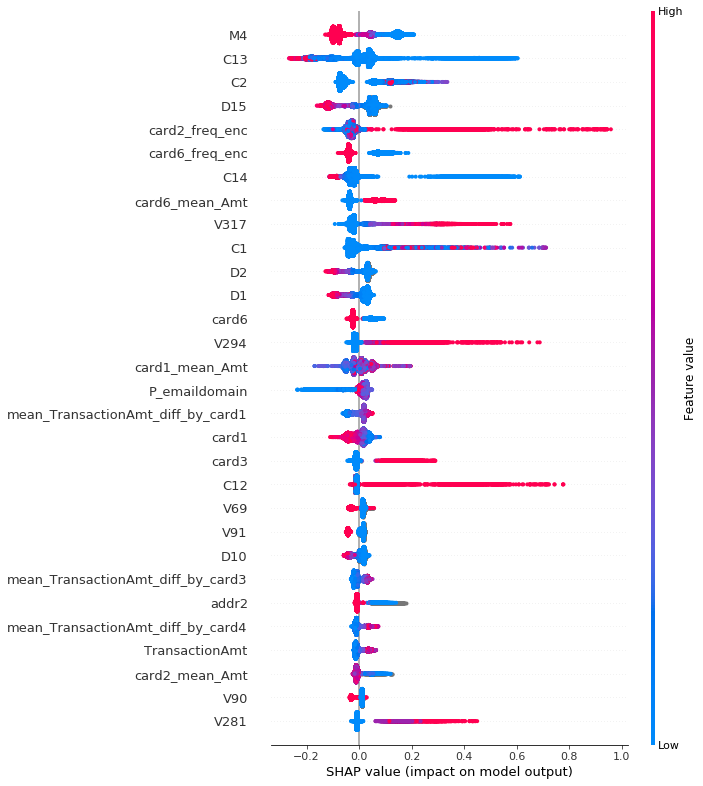

In [122]:
shap_test = shap.TreeExplainer(updated_catb_model).shap_values(X)
shap.summary_plot(shap_test, X, max_display=30)

In [116]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(updated_catb_model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [119]:
vals = np.abs(shap_values).mean(0)
shap_feature_importance = pd.DataFrame(list(zip(train.columns,vals)),columns=['feature','shap_values'])
shap_feature_importance.sort_values(by=['shap_values'],ascending=False,inplace=True)

shap_feature_importance.head(20)

,feature,shap_values
48,M3,0.096061
28,C12,0.083928
17,C1,0.083252
44,D14,0.062059
411,card1_freq_enc,0.056282
415,card5_freq_enc,0.054548
29,C13,0.053836
408,mean_TransactionAmt_diff_by_card5,0.047161
370,V316,0.047130
16,R_emaildomain,0.043589


### Выводы:

 - Feature Engineering проведен успешно, что сказалось на заметном приросте качества
 - Рейтинги отобранных групп признаков при помощи Shap, PI, AUC, довольно сильно отличаются друг от друга
 - Тесты на данных конкурса показали различное качество (в пределах 3-5%) на выборках равного размера. В данном случае, наиболее высокое качество имеют признаки, отобранные по AUC метрике